In [1]:
%load_ext autoreload
%autoreload 2

import git
from git import Repo

from unidiff import PatchSet

import subprocess
import json
import pandas as pd
import numpy as np
import matplotlib
import sys
import matplotlib.pyplot as plt
import sklearn
import ipywidgets as widgets


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import tree
from sklearn.preprocessing import OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from src.edit_distance_feature import edit_distance_feature

from src.reorderer import *
from src.reordering_analyzer import ReorderingAnalyzer

In [2]:
mutants_and_tests = pd.read_pickle('data/jinja_full_with_context.pkl')


mutants_and_tests.reset_index()
mutants_and_tests["outcome"] = mutants_and_tests["outcome"].astype('bool')
mutants_and_tests["outcome"]
display(mutants_and_tests)
print(mutants_and_tests.columns)

,mutant_id,contains_branch_mutant,contains_equality_comparison_mutant,contains_loop_mutant,contains_math_operands_mutant,current_line,line_number_changed,modified_file_path,modified_method,previous_line,...,setup_outcome,setup_duration,call_outcome,call_duration,teardown_outcome,teardown_duration,contains_branch_execution,contains_loop_execution,contains_math_operands_execution,contains_equality_comparison_execution
0,2092.0,1.0,1.0,1.0,1.0,"fields = (""XXtemplateXX"", ""names"", ""with_co...",369.0,src/jinja2/nodes.py,FromImport,,...,True,0.037701,True,0.005925,True,0.000302,None,None,None,None
1,2092.0,1.0,1.0,1.0,1.0,"fields = (""XXtemplateXX"", ""names"", ""with_co...",369.0,src/jinja2/nodes.py,FromImport,,...,True,0.000324,True,0.001251,True,0.000410,None,None,None,None
2,2092.0,1.0,1.0,1.0,1.0,"fields = (""XXtemplateXX"", ""names"", ""with_co...",369.0,src/jinja2/nodes.py,FromImport,,...,True,0.000572,True,0.000759,True,0.000170,None,None,None,None
3,2092.0,1.0,1.0,1.0,1.0,"fields = (""XXtemplateXX"", ""names"", ""with_co...",369.0,src/jinja2/nodes.py,FromImport,,...,True,0.000247,True,0.001194,True,0.000166,None,None,None,None
4,2092.0,1.0,1.0,1.0,1.0,"fields = (""XXtemplateXX"", ""names"", ""with_co...",369.0,src/jinja2/nodes.py,FromImport,,...,True,0.000249,True,0.000807,True,0.000216,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3624065,1353.0,1.0,1.0,1.0,1.0,"if self.stream.current.type == ""XXeofXX"":",176.0,src/jinja2/parser.py,parse_statements,,...,True,0.000258,True,0.124593,True,0.000143,None,None,None,None
3624066,1353.0,1.0,1.0,1.0,1.0,"if self.stream.current.type == ""XXeofXX"":",176.0,src/jinja2/parser.py,parse_statements,,...,True,0.000187,True,0.007196,True,0.000135,None,None,None,None
3624067,1353.0,1.0,1.0,1.0,1.0,"if self.stream.current.type == ""XXeofXX"":",176.0,src/jinja2/parser.py,parse_statements,,...,True,0.000179,True,0.004037,True,0.000135,None,None,None,None
3624068,1353.0,1.0,1.0,1.0,1.0,"if self.stream.current.type == ""XXeofXX"":",176.0,src/jinja2/parser.py,parse_statements,,...,True,0.000172,True,0.000136,True,0.000124,False,False,False,True


Index(['mutant_id', 'contains_branch_mutant',
       'contains_equality_comparison_mutant', 'contains_loop_mutant',
       'contains_math_operands_mutant', 'current_line', 'line_number_changed',
       'modified_file_path', 'modified_method', 'previous_line', 'repo_path',
       'outcome', 'test_id', 'full_name', 'name', 'filepath', 'duration',
       'setup_outcome', 'setup_duration', 'call_outcome', 'call_duration',
       'teardown_outcome', 'teardown_duration', 'contains_branch_execution',
       'contains_loop_execution', 'contains_math_operands_execution',
       'contains_equality_comparison_execution'],
      dtype='object')


# Data Preparation

### Cleansing

In [3]:
# Encode None as false in the context stuff
for column in ["contains_branch_mutant", "contains_loop_mutant", "contains_math_operands_mutant", "contains_equality_comparison_mutant",
               "contains_branch_execution", "contains_loop_execution", "contains_math_operands_execution", "contains_equality_comparison_execution",
                "teardown_outcome", "setup_outcome", "call_outcome", "outcome"]:
    mutants_and_tests.loc[mutants_and_tests[column].isnull(), column] = False
    #mutants_and_tests.loc[np.isnan(mutants_and_tests[column]), column] = False

#Encode NaN as 0 in the duration stuff
for column in ["teardown_duration", "setup_duration", "call_duration"]:
    mutants_and_tests.loc[pd.isnull(mutants_and_tests[column]), column] = 0

In [4]:
# Sometimes, test_ids only occur very rarely and make problems in the reordering. They can be deleted here from the dataset


test_ids_to_kill = [] # e.g.: [82, 83]
for test_id in test_ids_to_kill:
    mutants_and_tests = mutants_and_tests.loc[mutants_and_tests['test_id'] != test_id]
mutants_and_tests = mutants_and_tests.copy()

### Feature Generation and Encoding

In [5]:
# Add edit distance feature

# Fix object and fill null values
mutants_and_tests["name"] = mutants_and_tests["name"].astype('string')
mutants_and_tests["modified_method"] = mutants_and_tests["modified_method"].astype('string')

mutants_and_tests["name"].loc[pd.isnull(mutants_and_tests["name"])] = ""
mutants_and_tests["modified_method"].loc[pd.isnull(mutants_and_tests["modified_method"])] = ""

mutants_and_tests['edit_distance'] = edit_distance_feature(
    mutants_and_tests['modified_method'],
    mutants_and_tests['name']
)
mutants_and_tests['edit_distance'].value_counts()

25     161225
26     158725
24     158430
28     150826
23     146799
        ...  
110        20
4          17
0          16
3           1
2           1
Name: edit_distance, Length: 97, dtype: int64

In [6]:
# Now create X and y, since we will encode columns in X and want to keep them in mutants_and_tests
X = mutants_and_tests.drop(['outcome'], axis=1)
y = mutants_and_tests["outcome"]

# Throw out nan values:
previous_length = len(X)
X = X.loc[mutants_and_tests.isnull().any(axis=1) == False]
y = mutants_and_tests["outcome"].loc[mutants_and_tests.isnull().any(axis=1) == False]
print("Kicked out " + str(previous_length - len(X)) + " values from " + str(previous_length) + " total values. (" + str((1 - len(X) / previous_length) * 100) + "%)")

Kicked out 145 values from 3624070 total values. (0.004001026470235036%)


In [7]:
# Encode stuff we want to encode:
encoded_columns = ["modified_method", "modified_file_path", "name", "filepath", "current_line", "previous_line"]
# Encoding

enc = OrdinalEncoder()
X_enc = enc.fit_transform(X[encoded_columns])
i = 0
for column_name in encoded_columns:
    X[column_name] = X_enc[:,i]
    i += 1


### Feature Selection
(you can reload if you want all features selected)

In [8]:
# Dangerous features are features you probably don't want in your dataset, since they can spoil y
dangerous_features = ['setup_outcome', 'setup_duration', 'call_outcome', 'call_duration', 'teardown_outcome', 'teardown_duration']

# Unencoded
unencoded_features = ['repo_path', 'full_name']

X = X.drop(dangerous_features, axis=1).drop(unencoded_features, axis=1)


In [9]:

w = widgets.SelectMultiple(
    options=X.columns,
    value=tuple(X.columns),
    rows=len(X.columns),
    description='Select the desired features',
    disabled=False
)
w

SelectMultiple(description='Select the desired features', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,…

In [10]:
feature_columns = list(w.value)
X = X[feature_columns]

In [11]:
# Split test and train
split_mutant = X['mutant_id'].max() * 0.7
print("split_mutant is " + str(split_mutant))
# TODO: this has to split of whole
train = X.loc[X['mutant_id'] < split_mutant]
test = X.loc[X['mutant_id'] >= split_mutant]

X_train = X.loc[X['mutant_id'] < split_mutant]
y_train = y.loc[X['mutant_id'] < split_mutant]

X_test = X.loc[X['mutant_id'] >= split_mutant]
y_test = y.loc[X['mutant_id'] >= split_mutant]

# shuffle alternative: X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=420, shuffle=True)


split_mutant is 3470.6


# Reordering

To help you reorder the tests, there are some usefull functionalities in ```src.reorderer```
The most usefull is probably the ```BinaryPredictionReorderer```. You can hand in a binary predictor for failing tests, and it will autmatically
generate an order of the tests that has the predicted failing tests in front. As an easy example, you can put in a DecisionTree Classifier and see how it performs. (Hint: Use the sparsify switch in the cell loading the dataset (2. cell in the notebook) for fast tryout analysis)

In [20]:
class BaselineBinaryPredictor:
    
    def name(self):
        return "BaselineBinaryPredictor"
    def fit(self, X_train, y_train):
        self.X_train = X_train
    
    
    def predict(self, X_test):
        predictions = []
        for index, row in X_test.iterrows():
            # Select only rows from X_train with the same test_id
            correct_tests = self.X_train.loc[self.X_train['test_id'] == row['test_id']]
            #print("Test_id: " + str(row['test_id']))
            #print("Mutant_id: " + str(row['mutant_id']))
            #print(len(correct_tests))
            mutant_id = row['mutant_id']
            #print(correct_tests)
            nearest_mutant_id_index = abs(correct_tests['mutant_id'] - mutant_id).idxmin()
            #print(nearest_mutant_id_index)
            #print(y_train)
            predictions.append(y_train[nearest_mutant_id_index])
        return predictions
        
bpr_baseline = BinaryPredictionReorderer(BaselineBinaryPredictor())
bpr_baseline.fit(X_train, y_train)
bpr_baseline_order = bpr_baseline.predict(X_test)



## Evaluation

In [ ]:
evaluation = ReorderingAnalyzer([
    NaiveReorderer(),
    AverageReorderer(),
    QTF(),
    BinaryPredictionReorderer(tree.DecisionTreeClassifier(ccp_alpha=0.001)),
    BinaryPredictionReorderer(KNeighborsClassifier()),
    BinaryPredictionReorderer(ExtraTreesClassifier(n_estimators=250,
                              random_state=420)),
    #BinaryPredictionReorderer((make_pipeline(StandardScaler(), SVC(gamma='auto')))),
    OrdinalPredictionReorderer(ExtraTreesClassifier(random_state=420)),
    BinaryPredictionReorderer(GradientBoostingClassifier(random_state=420)),
    OrdinalPredictionReorderer(GradientBoostingClassifier(random_state=420))
])
evaluation.fit(X_train, y_train)
evaluation.predict(X_test)
evaluation_data = evaluation.evaluate(mutants_and_tests)
evaluation_data

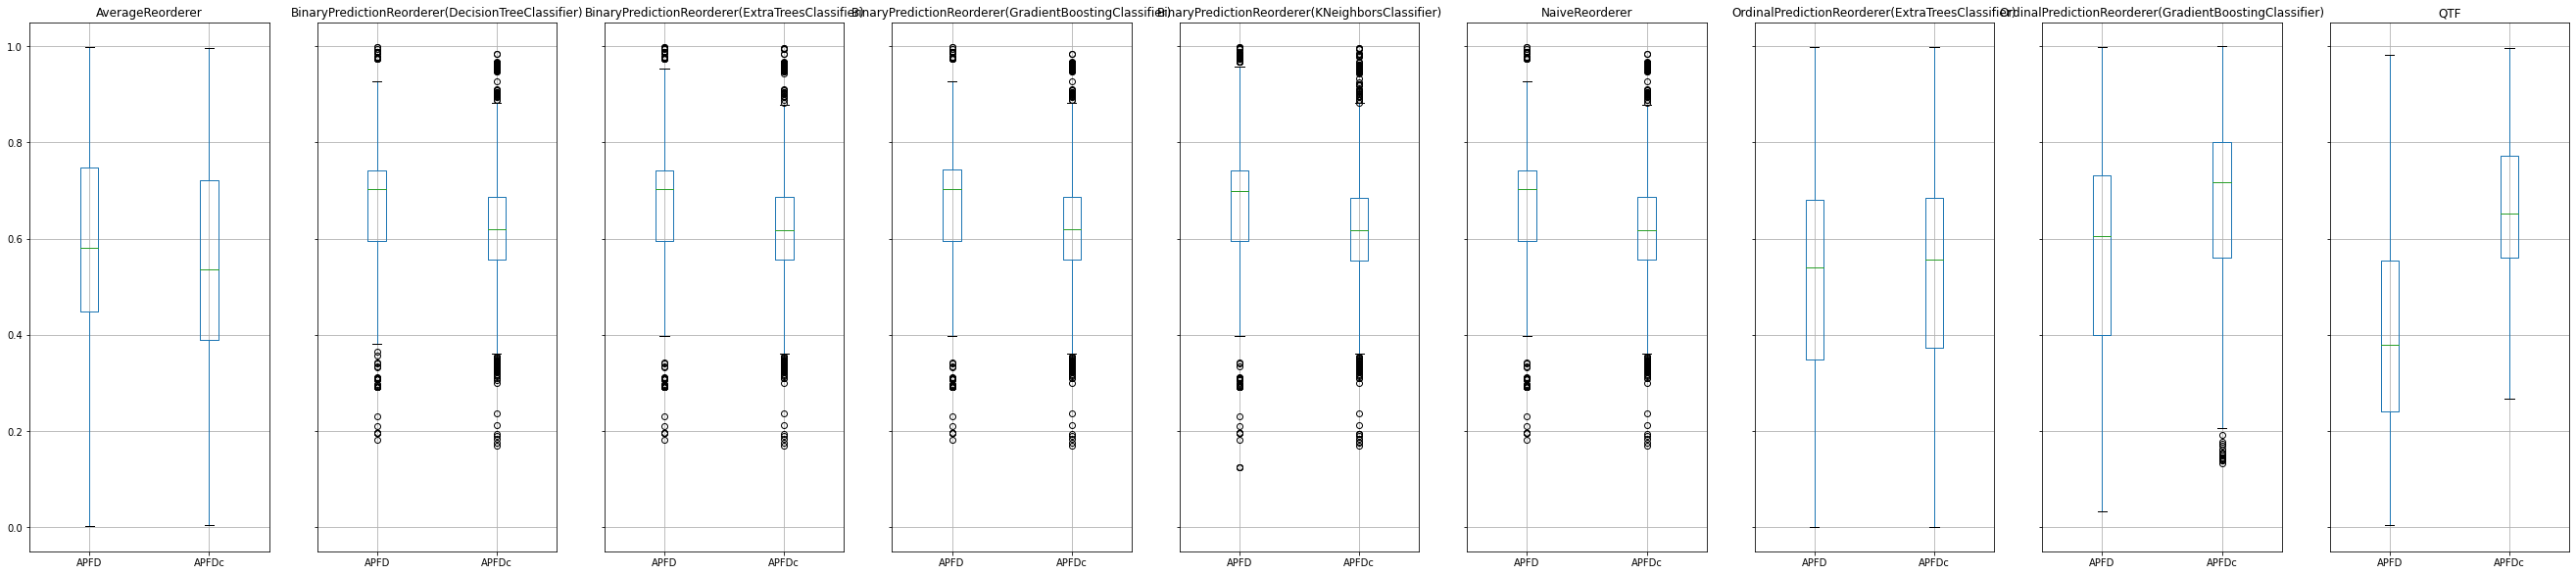

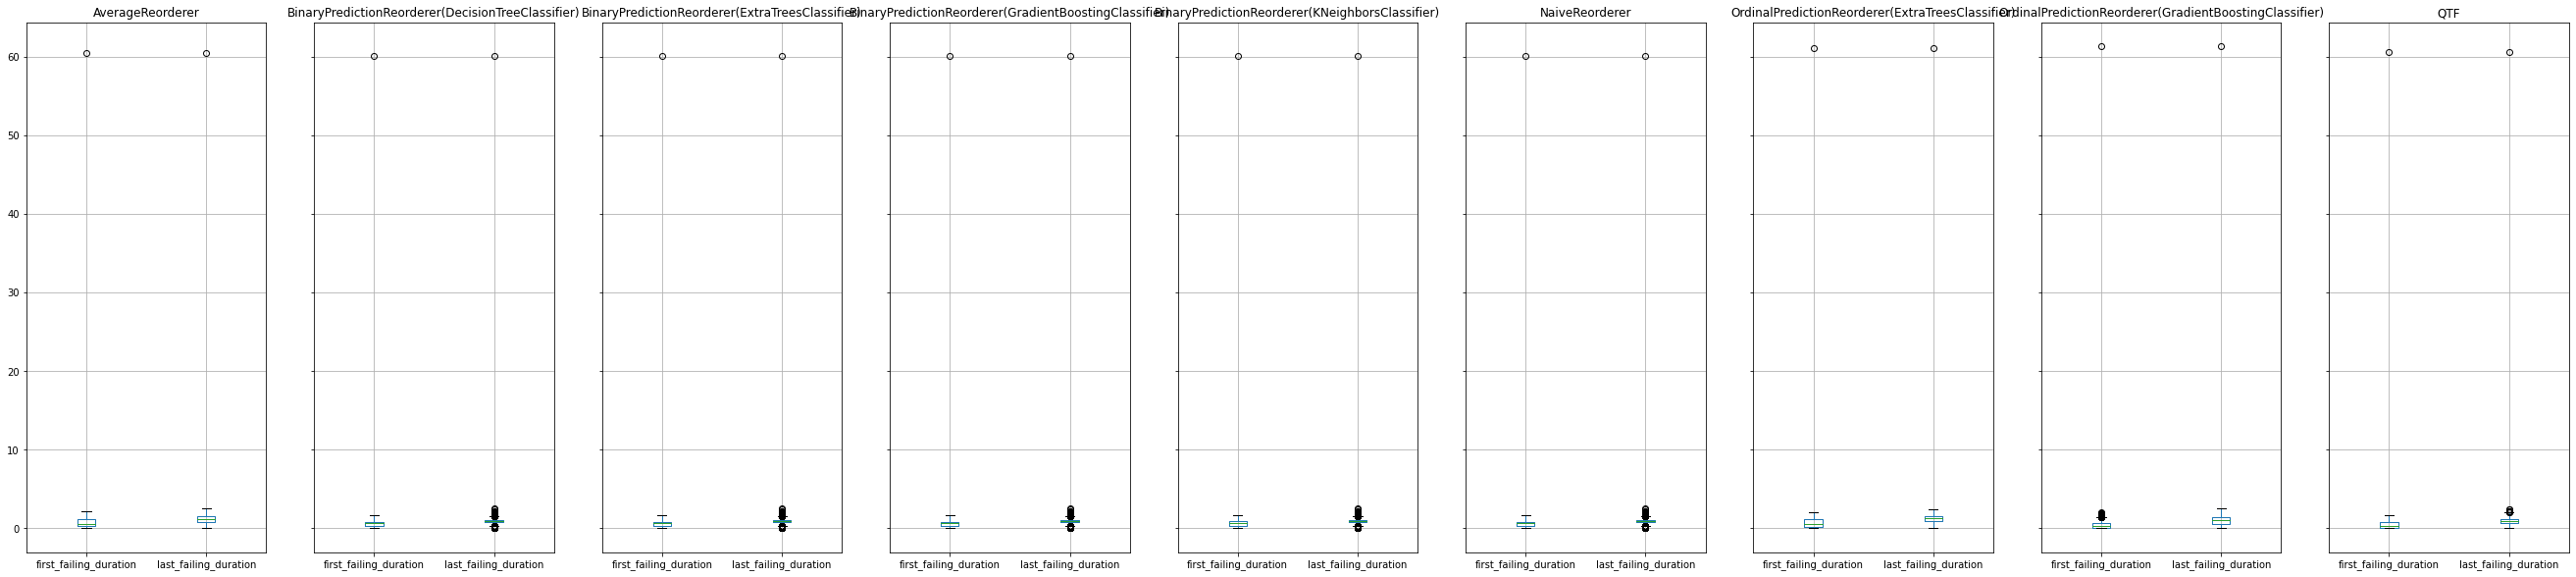

In [16]:
evaluation.boxplot()

In [24]:
evaluation_data.to_csv()

',apfd_avg,apfd_max,apfd_min,first_failing_duration_avg,last_failing_duration_avg\nNaiveReorderer,0.6757561813037656,0.99933598937583,0.1826029216467463,0.6514302746470946,0.9835933404696844\nAverageReorderer,0.5478062771037907,0.99800796812749,0.0019920318725099584,0.7895971091861551,1.2538712232009224\nBinaryPredictionReorderer(DecisionTreeClassifier),0.676243812361596,0.99933598937583,0.1826029216467463,0.6446214980616246,0.984884913698125\nBinaryPredictionReorderer(KNeighborsClassifier),0.6739219950893162,0.99933598937583,0.12416998671978752,0.6480495035347008,0.981753419455672\nBinaryPredictionReorderer(ExtraTreesClassifier),0.6760913718971708,0.99933598937583,0.1826029216467463,0.65014486582865,0.9828686538191006\nBinaryPredictionReorderer(GradientBoostingClassifier),0.676162781378574,0.99933598937583,0.1826029216467463,0.6459914348243582,0.9836014315139415\n'